In [1]:
from scprint import scPrint
from scdataloader import Preprocessor

from bengrn import BenGRN, get_sroy_gt, FILEDIR
import scanpy as sc

from anndata.utils import make_index_unique
from bengrn import compute_genie3, get_GT_db
from grnndata import utils as grnutils
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [2]:
genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
NUM_GENES = 5000
MAXCELLS = 1024

# han / full


In [4]:
metrics = {}

In [3]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining
filtered out 0 cells, 5520 renamining
Removed 0 genes.
startin QC
Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 1099.81 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.02843960638719677 
recall:  0.7882117882117882 
random precision: 0.027387640449438203


  0%|                                                                                            | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1336.99it/s]


Area Under Precision-Recall Curve (AUPRC):  0.028807301001836202
EPR: 1.139258511354377


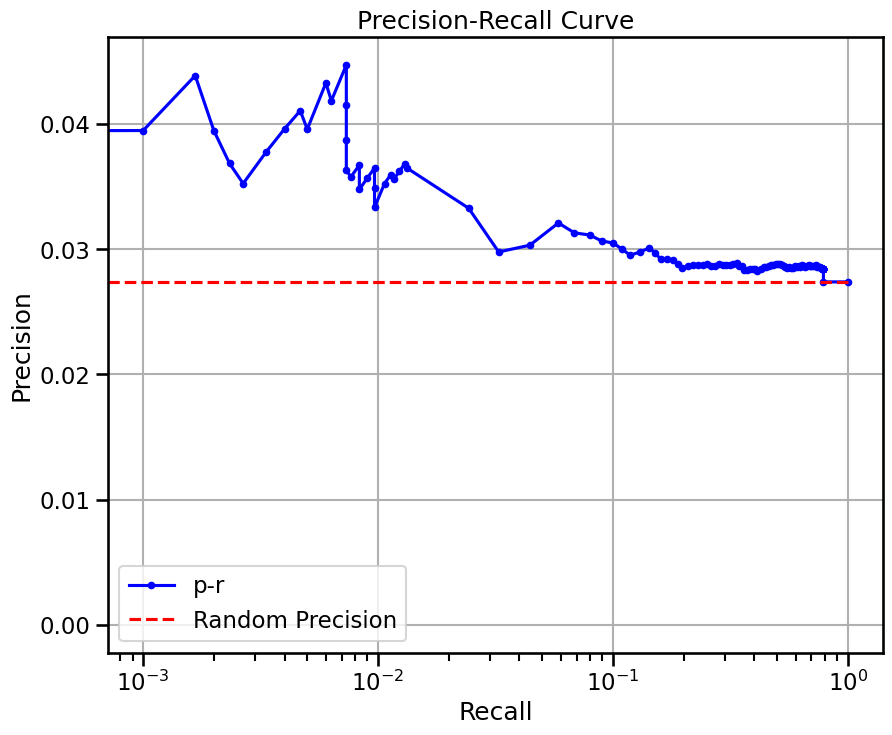

In [5]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.highly_variable]

genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
metrics['genie3_han'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.04380935316251568 
recall:  0.16283716283716285 
random precision: 0.027387640449438203


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1251.38it/s]


Area Under Precision-Recall Curve (AUPRC):  0.031023304648715895
EPR: 1.912720869024544


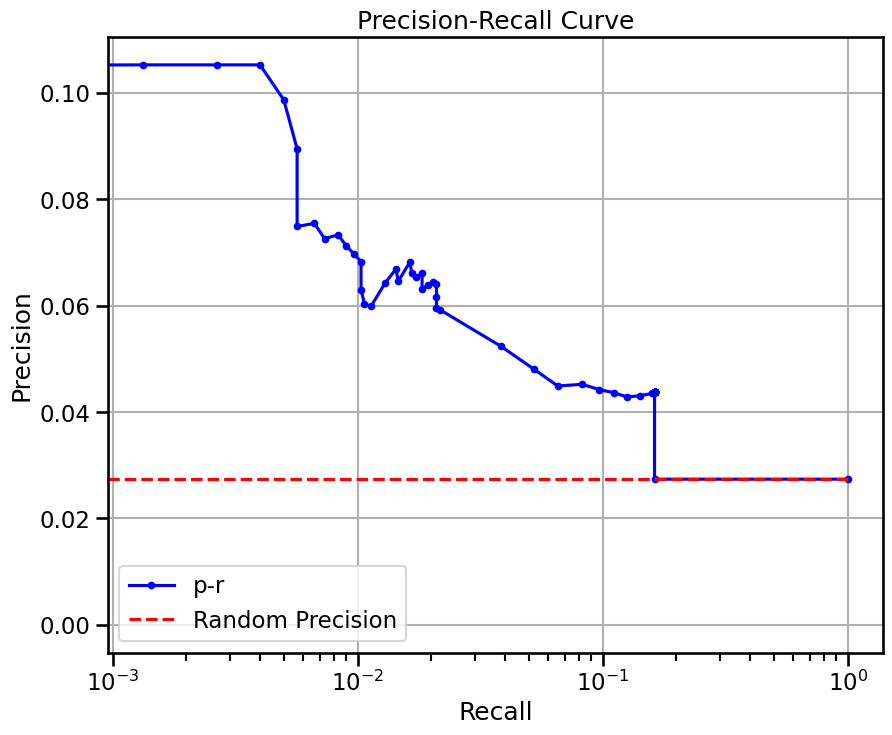

In [6]:
genie_grn.varp["GRN"] = genie_grn.varp["GRN"].T
metrics['genie3_han'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


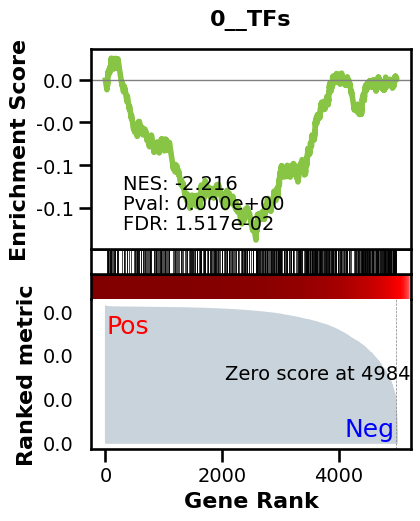

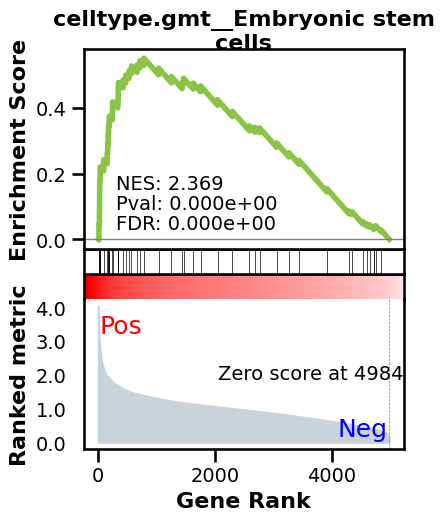

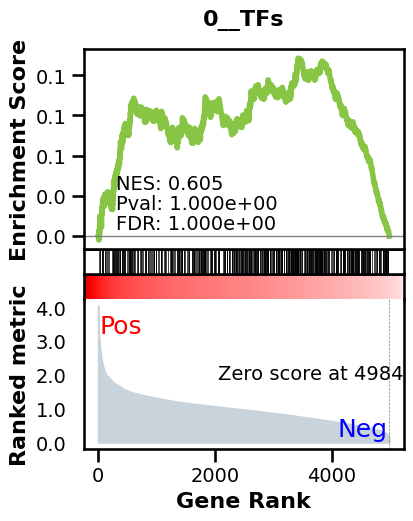

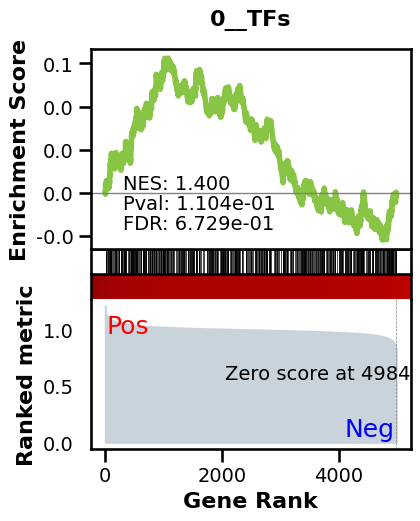

_________________________________________
TF specific enrichment
found some significant results for  5.660377358490566 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3755 genes
intersection pct: 0.753259779338014
precision:  0.0015509777705755702 
recall:  0.7478670334281319 
random precision: 0.0015216081984808748


 98%|████████████████████████████████████████████████████████████████████████████████  | 125/128 [00:06<00:00, 25.04it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████████████████████████████████████████████████████████████████████████████| 128/128 [00:06<00:00, 18.63it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0016954318538938543
EPR: 1.7813454668198887


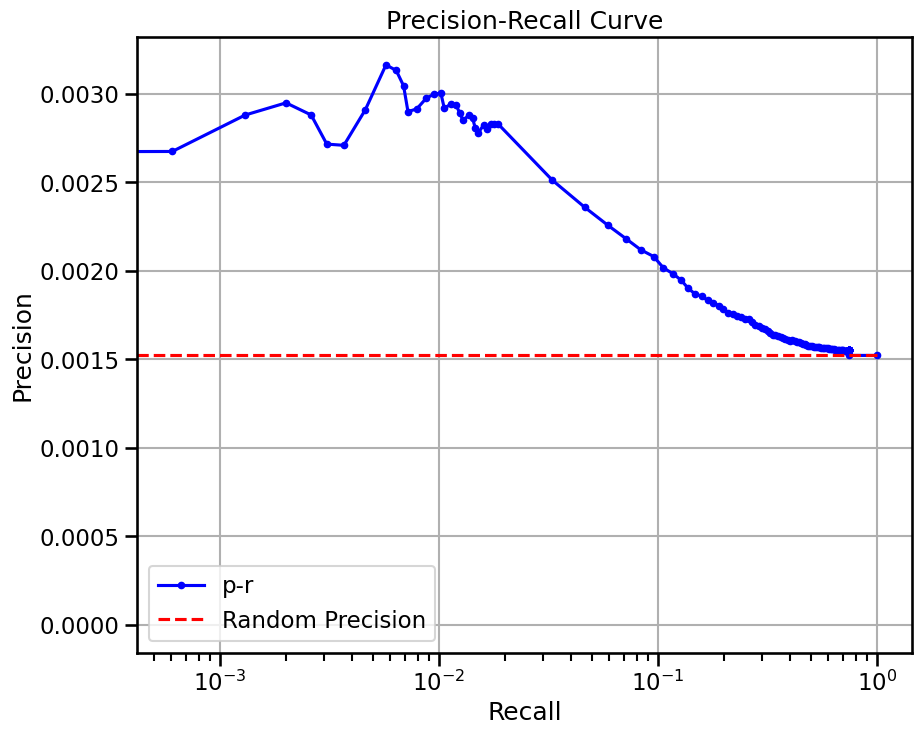

In [6]:
metrics['genie3_han_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.2724142202403072 
recall:  0.8485386321983216 
random precision: 0.2536653877774733


 82%|██████████████████████████████████████████████████████████████████▍              | 105/128 [00:00<00:00, 535.48it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 527.68it/s]


Area Under Precision-Recall Curve (AUPRC):  0.28426164156028955
EPR: 1.3422184314282455


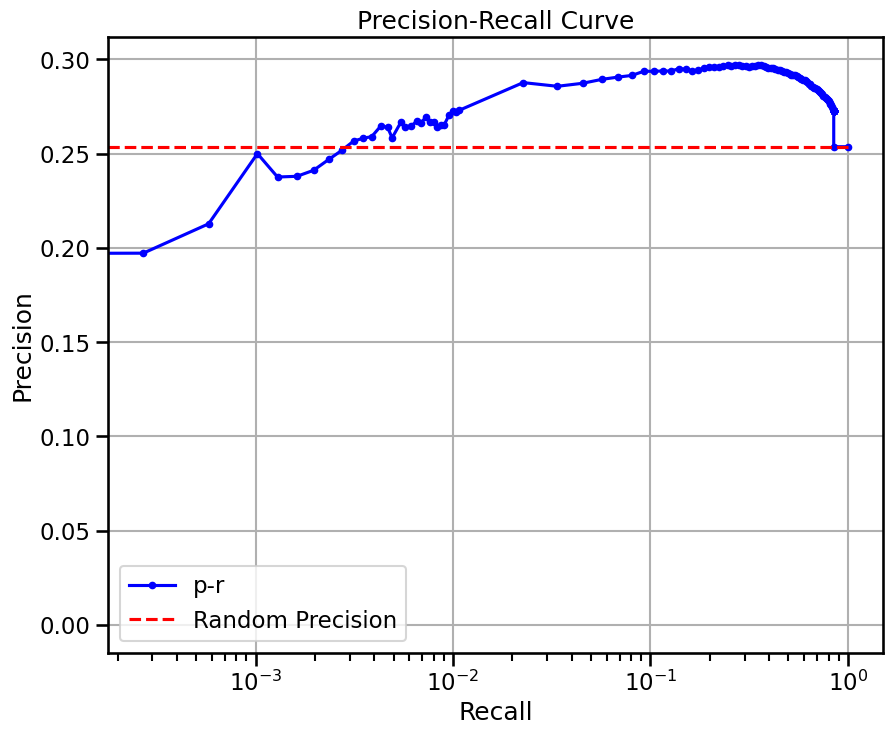

In [7]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['genie3_han_chip'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.06778837605895861 
recall:  0.6328610838359752 
random precision: 0.0766273503783536


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 123/128 [00:00<00:00, 409.28it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 400.31it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0695670033880851
EPR: 0.9131783502154647


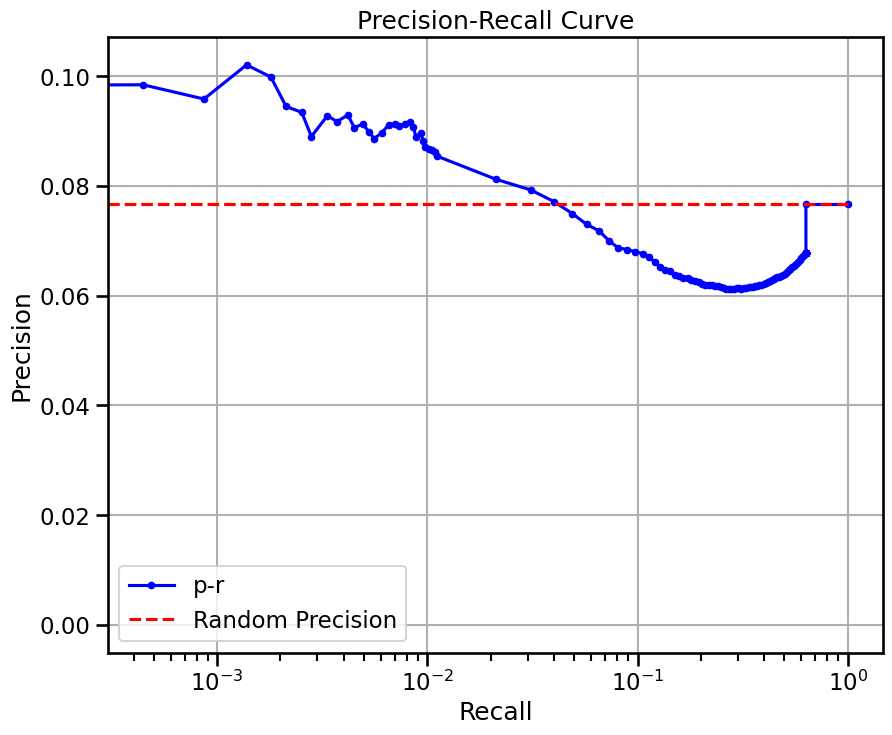

In [8]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['genie3_tf_han_ko'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 206.46 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.026904938094343998 
recall:  0.8111888111888111 
random precision: 0.027387640449438203


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1894.69it/s]


Area Under Precision-Recall Curve (AUPRC):  0.02925975251847749
EPR: 1.2441861431622765


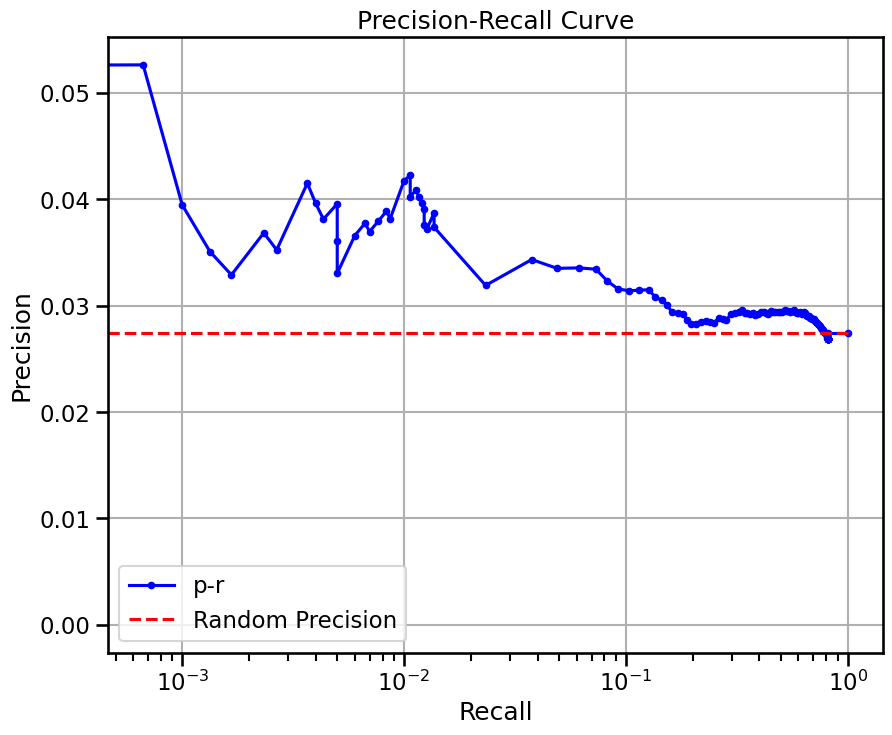

In [5]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]

genie_grn = compute_genie3(subadata, nthreads=20, regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
metrics['genie3_tf_han'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


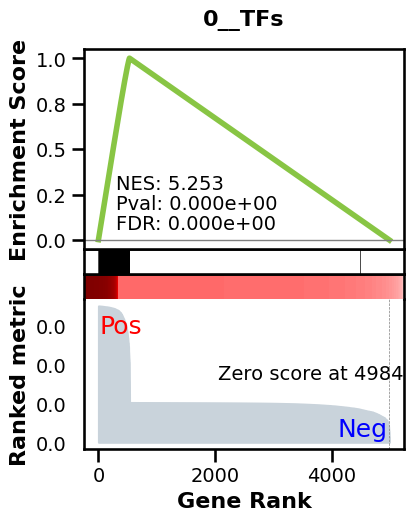

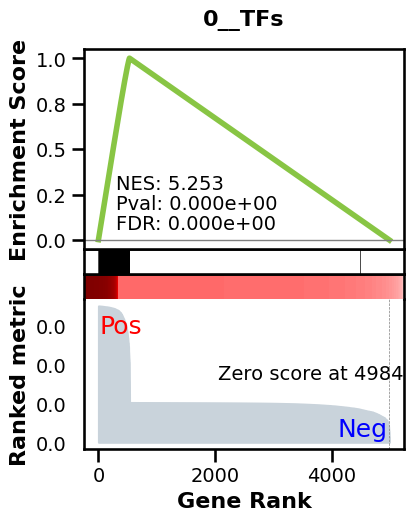

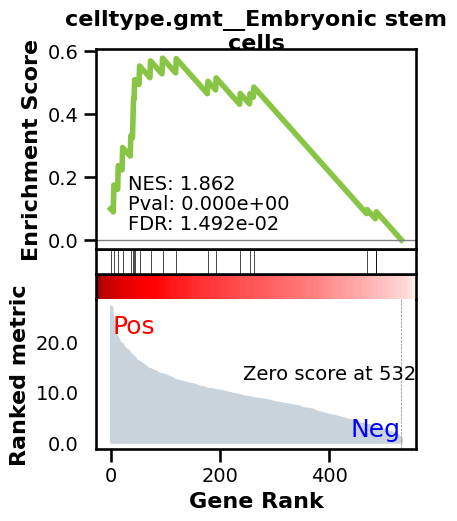

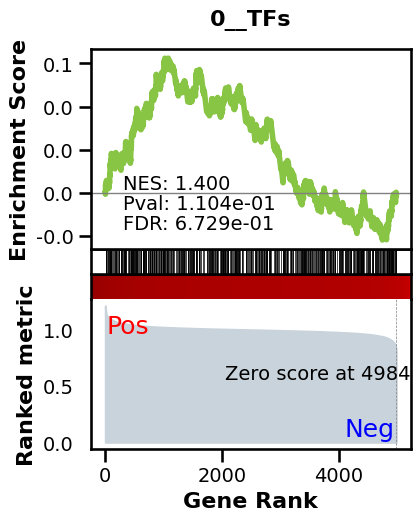

_________________________________________
TF specific enrichment
found some significant results for  7.547169811320755 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3755 genes
intersection pct: 0.753259779338014
precision:  0.006326896884855623 
recall:  0.5044057998041866 
random precision: 0.0015216081984808748


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 126/128 [00:07<00:00, 17.36it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████████████████████████████████████████████████████████████████████████████| 128/128 [00:07<00:00, 17.26it/s]


Area Under Precision-Recall Curve (AUPRC):  0.00479700864617249
EPR: 9.071017178058254


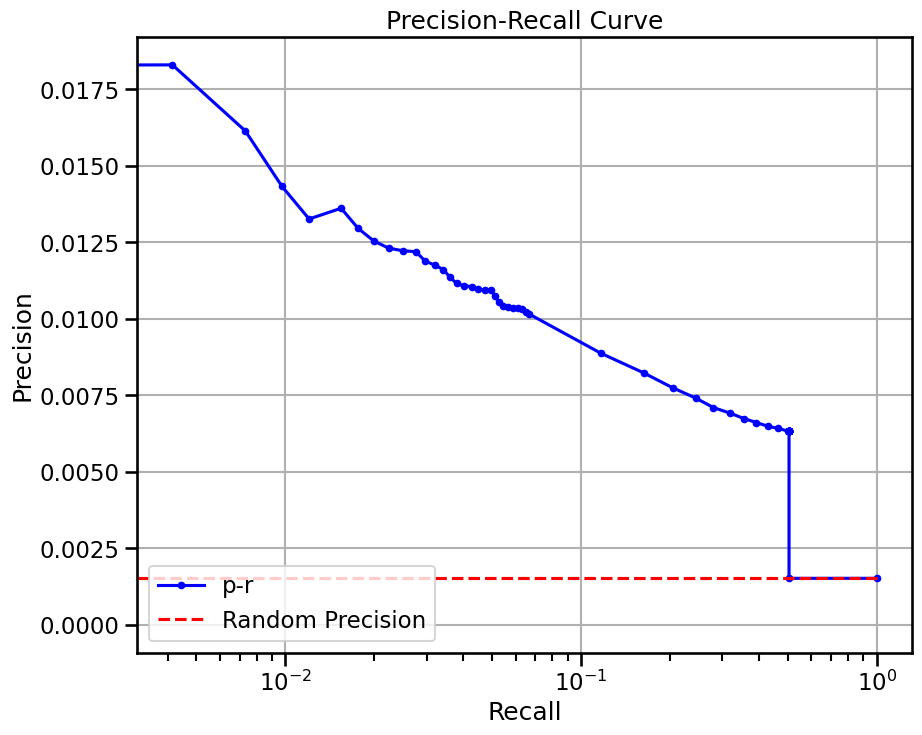

In [10]:
metrics['genie3_tf_han_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.2024859180369543 
recall:  0.5839297771775828 
random precision: 0.2536653877774733


 80%|████████████████████████████████████████████████████████████████▌                | 102/128 [00:00<00:00, 508.87it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 503.06it/s]


Area Under Precision-Recall Curve (AUPRC):  0.2429179237343337
EPR: 0.9639438170351119


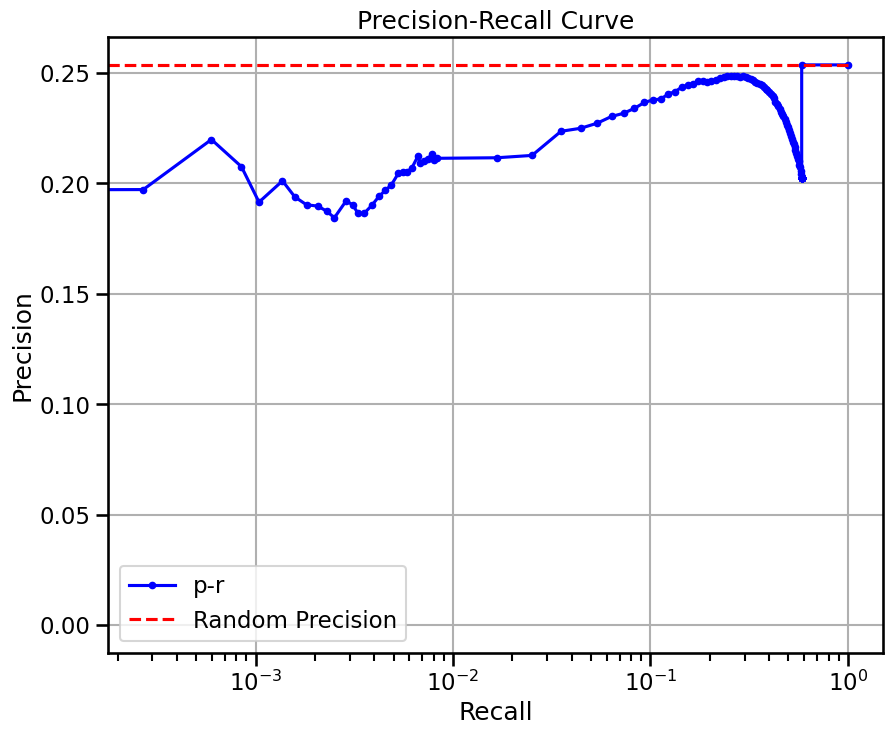

In [11]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['genie3_tf_han_chip'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.10245533382091736 
recall:  0.8023799504371815 
random precision: 0.0766273503783536


 95%|████████████████████████████████████████████████████████████████████████████▌    | 121/128 [00:00<00:00, 405.53it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 395.41it/s]


Area Under Precision-Recall Curve (AUPRC):  0.09546056911937667
EPR: 1.4734901989229148


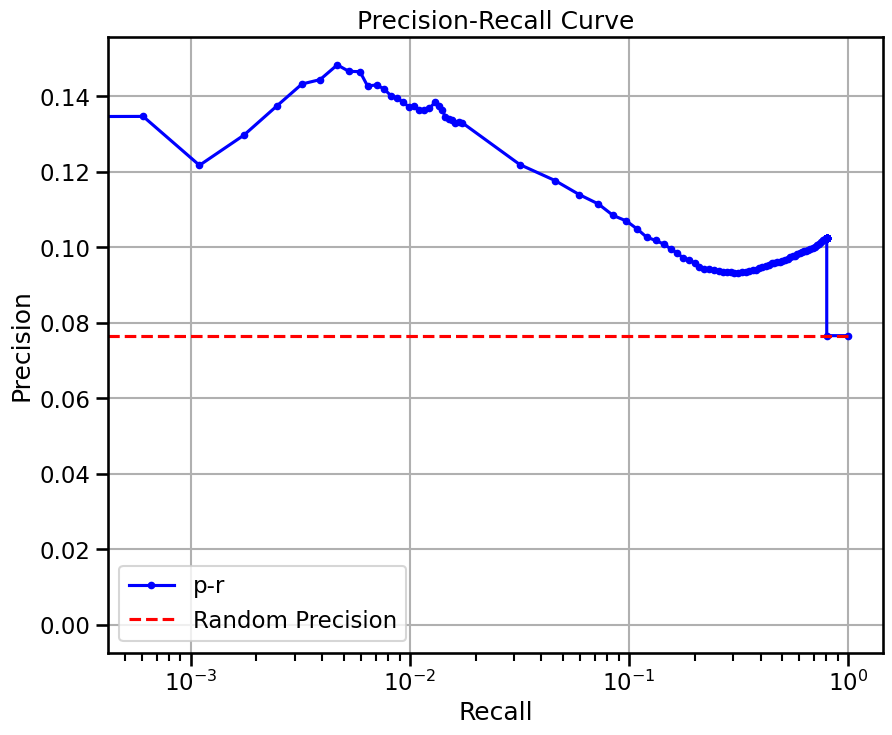

In [12]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['genie3_tf_han_ko'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

## trial with my own ESC

In [13]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining
filtered out 0 cells, 115 renamining
Removed 0 genes.
startin QC
Seeing 104 outliers (90.43% of total dataset):
done


(GRnnData object with n_obs × n_vars = 115 × 28466
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11563 elements,
 35)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 70.02 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.033063244330849964 
recall:  0.9375481881264457 
random precision: 0.03178726793701366


  0%|                                                                                            | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 2643.15it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03742249777543791
EPR: 1.3642821302714183


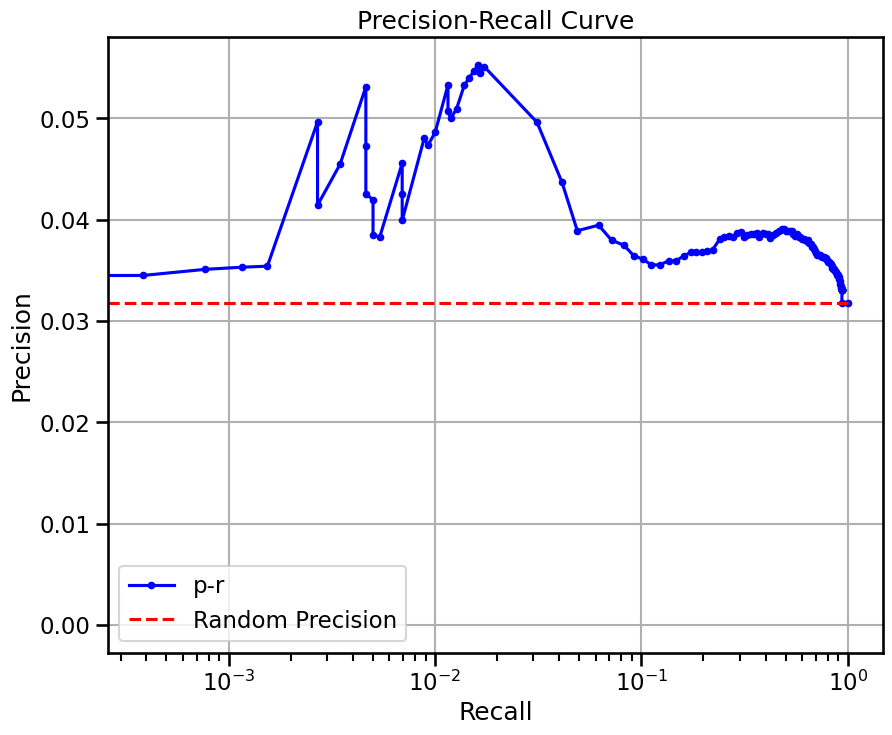

In [14]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20,
                            regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var.index = genie_grn.var['symbol']
metrics['genie3_tf_mine'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


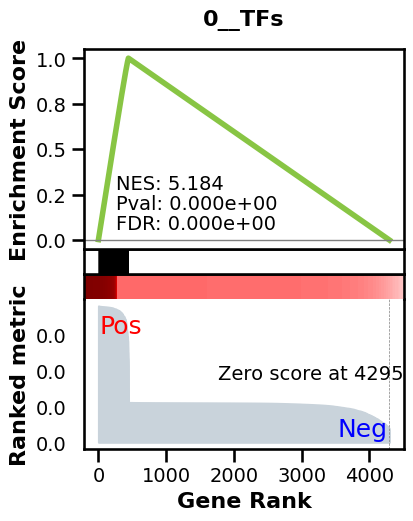

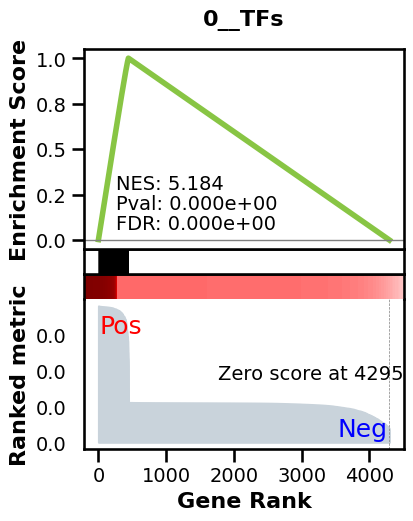

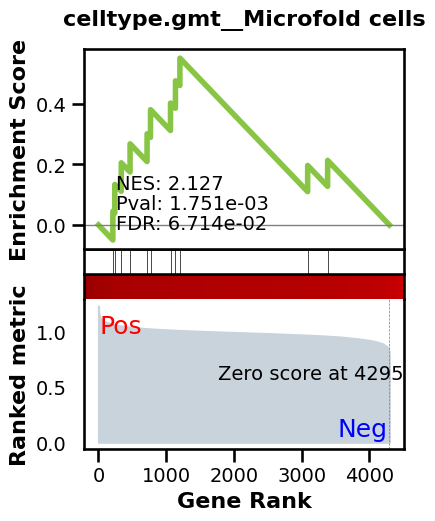

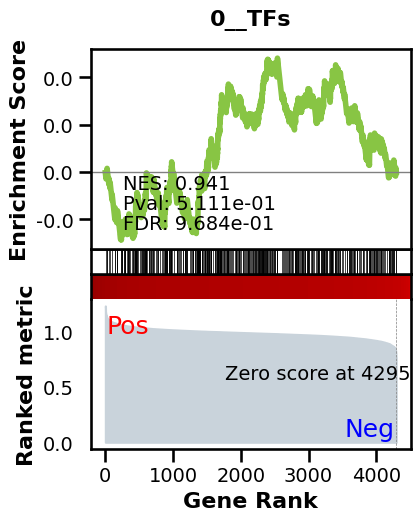

_________________________________________
TF specific enrichment
found some significant results for  2.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2828 genes
intersection pct: 0.6582867783985102
precision:  0.008008694247986186 
recall:  0.6704262730137668 
random precision: 0.0015082386504353604


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 126/128 [00:01<00:00, 65.35it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 65.74it/s]


Area Under Precision-Recall Curve (AUPRC):  0.00697257775491662
EPR: 9.414169349105721


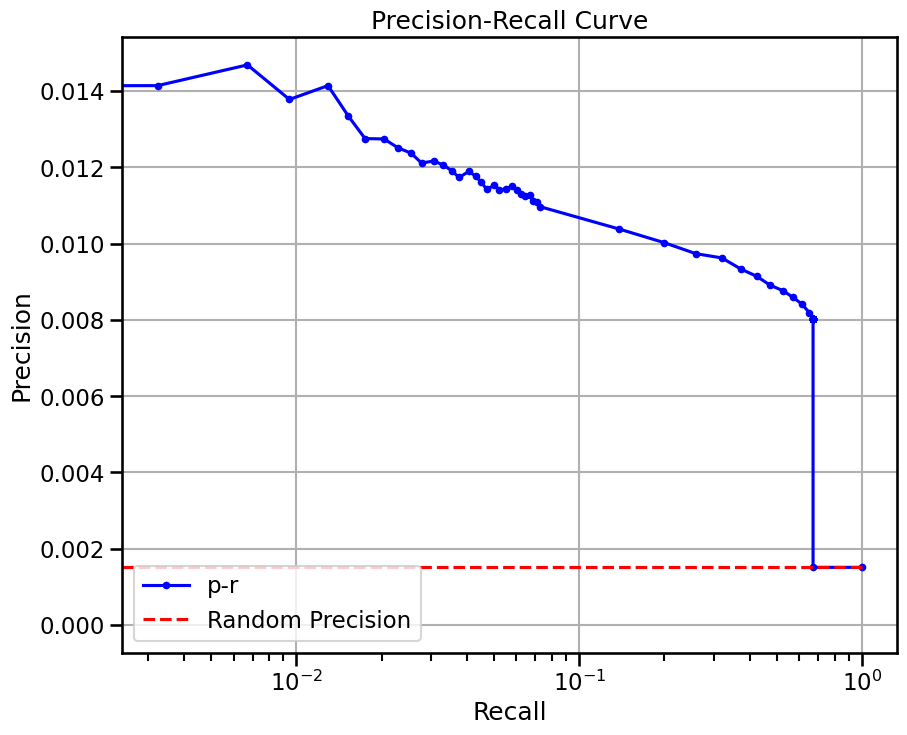

In [15]:
metrics['genie3_tf_mine_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 137.51 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.03644784534836891 
recall:  0.6977640709329221 
random precision: 0.03178726793701366


  0%|                                                                                            | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 2405.87it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03663091681828684
EPR: 1.350774101348534


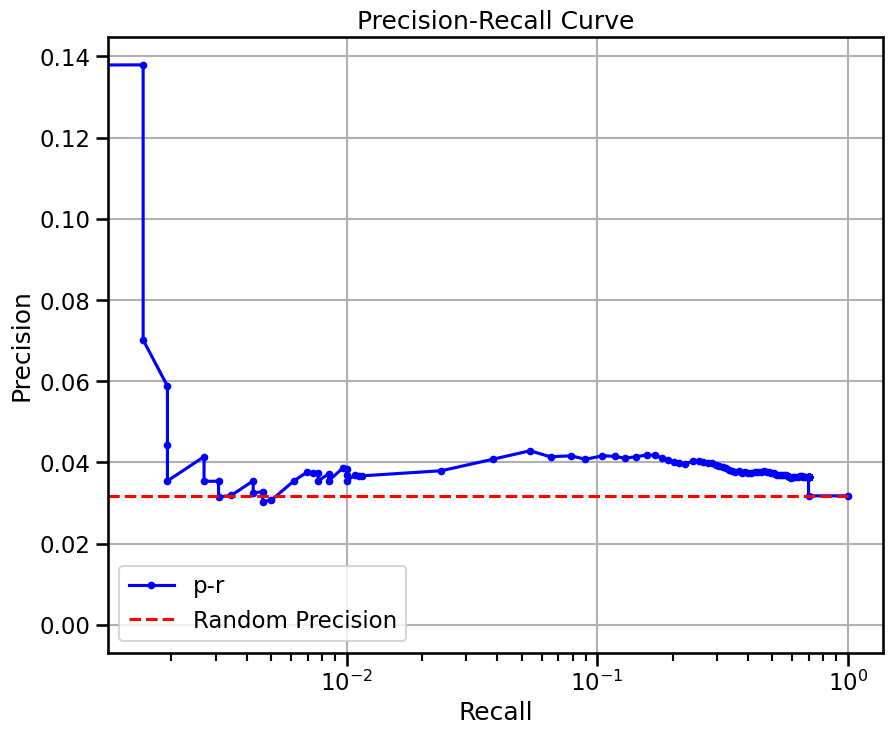

In [16]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
metrics['genie3_mine'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment
Top central genes: []


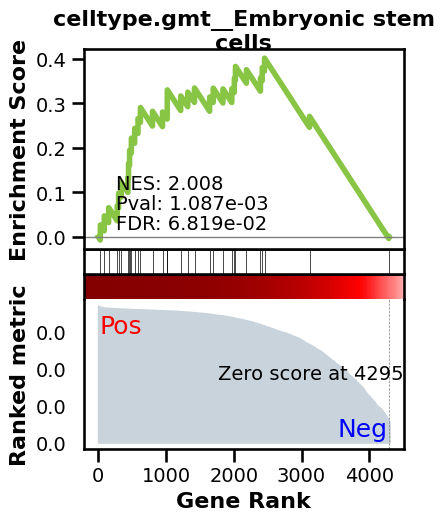

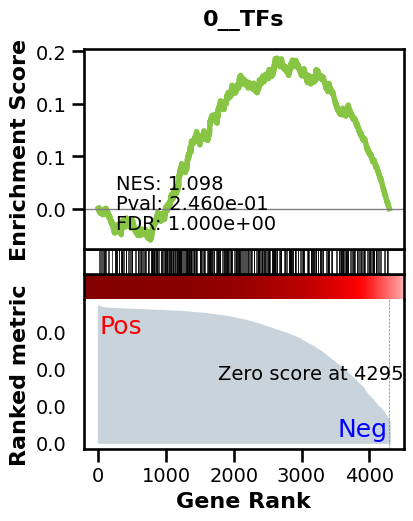

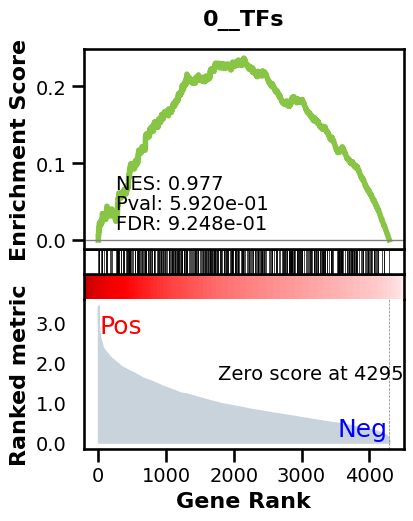

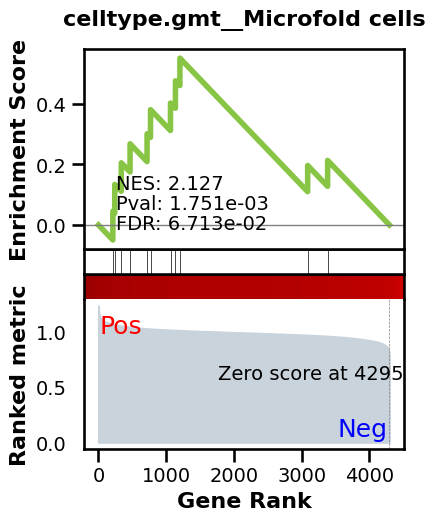

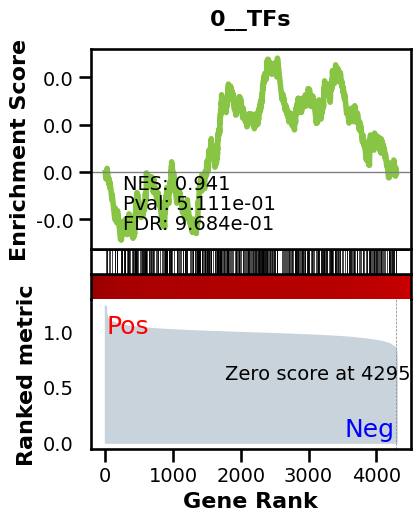

_________________________________________
TF specific enrichment
found some significant results for  5.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2828 genes
intersection pct: 0.6582867783985102
precision:  0.0017205164231326997 
recall:  0.6064853209487477 
random precision: 0.0015082386504353604


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 126/128 [00:01<00:00, 67.91it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 67.79it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0016917799348459203
EPR: 0.8243580779546159


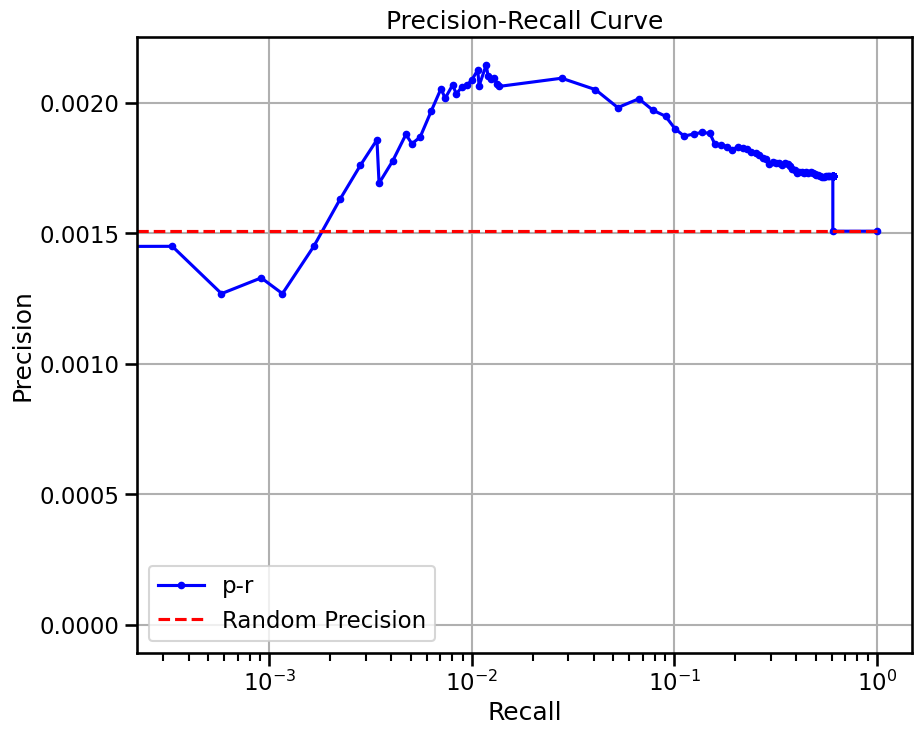

In [17]:
metrics['genie3_mine_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

## trial with the other two mouse dataset

In [18]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 2369 renamining
filtered out 0 cells, 2369 renamining
Removed 0 genes.
startin QC
Seeing 91 outliers (3.84% of total dataset):
done


(GRnnData object with n_obs × n_vars = 2369 × 6618
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7162 elements,
 31)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 156.23 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.031387000444755064 
recall:  0.592326139088729 
random precision: 0.04047724974721941


  0%|                                                                                            | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1370.15it/s]


Area Under Precision-Recall Curve (AUPRC):  0.030588562956143935
EPR: 0.4286855896714371


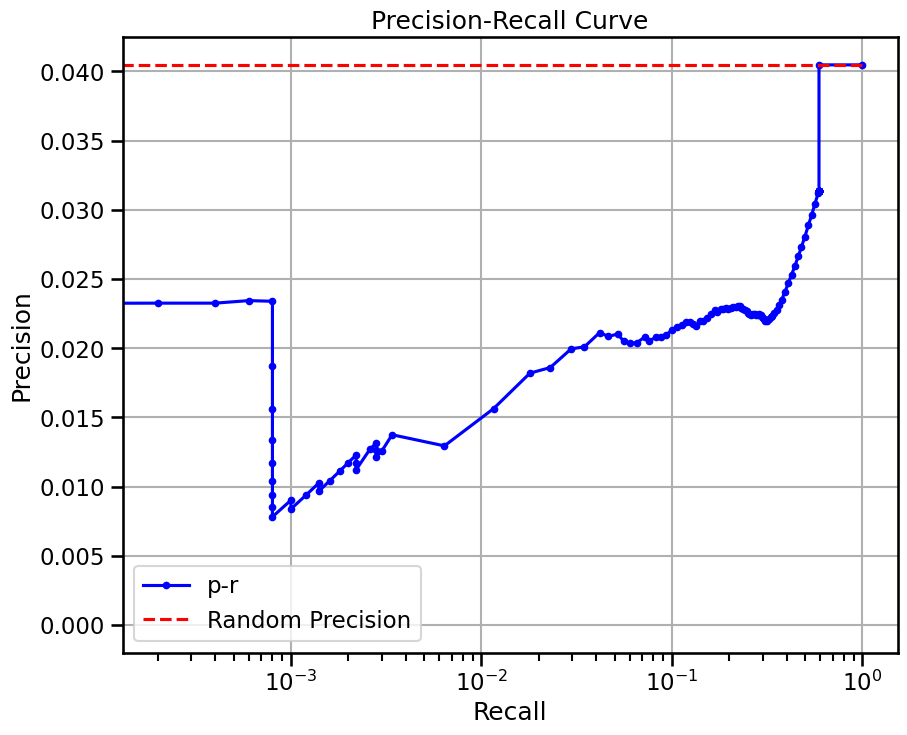

In [19]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=32,
                            regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
metrics['genie3_tf_tran'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.21857136260793278 
recall:  0.7764072956304947 
random precision: 0.1988584102547376


 88%|███████████████████████████████████████████████████████████████████████▌         | 113/128 [00:00<00:00, 596.15it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 562.84it/s]


Area Under Precision-Recall Curve (AUPRC):  0.2298472812497031
EPR: 1.4901344706070374


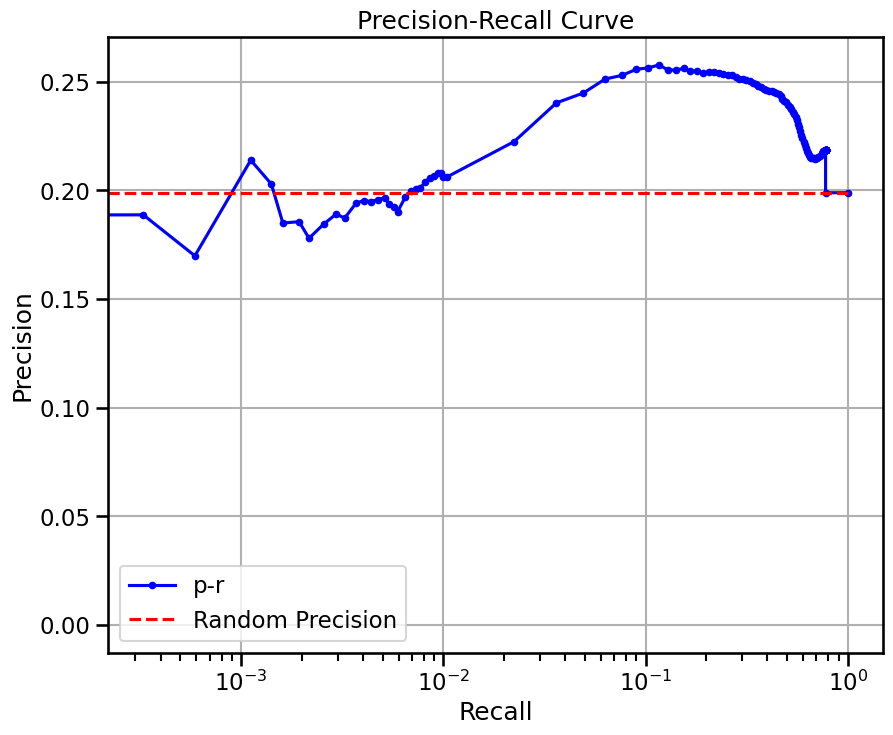

In [21]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['genie3_tf_tran_chip'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0938177728187809 
recall:  0.7662969116497264 
random precision: 0.07958310647896087


 99%|████████████████████████████████████████████████████████████████████████████████▎| 127/128 [00:00<00:00, 426.06it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 413.22it/s]


Area Under Precision-Recall Curve (AUPRC):  0.08280860160457229
EPR: 0.989081186309248


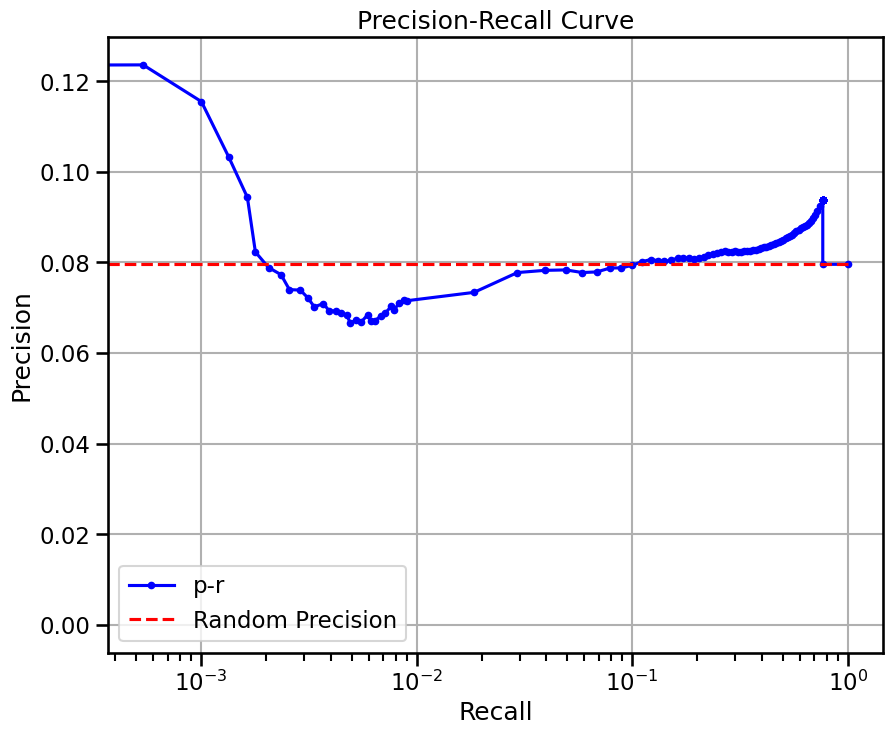

In [22]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['genie3_tf_tran_ko'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 529.65 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.06571045126656601 
recall:  0.5742279124315872 
random precision: 0.07958310647896087


 90%|████████████████████████████████████████████████████████████████████████▊        | 115/128 [00:00<00:00, 192.27it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 186.47it/s]


Area Under Precision-Recall Curve (AUPRC):  0.06983046795502276
EPR: 0.7490429321747619


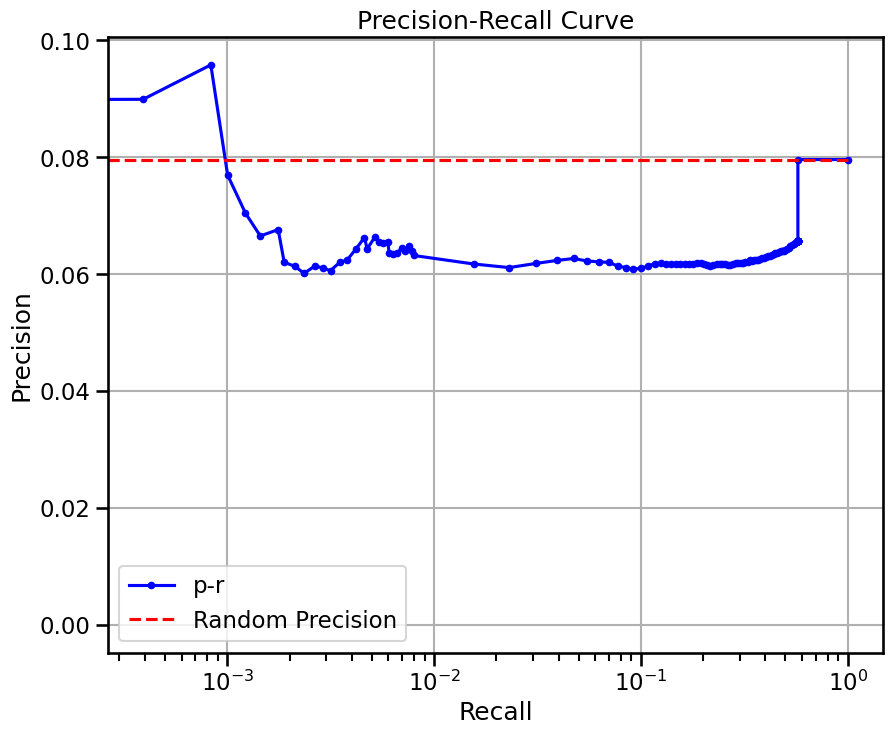

In [23]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
metrics['genie3_tran'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.19359486748001684 
recall:  0.6038249573546779 
random precision: 0.1988584102547376


 48%|███████████████████████████████████████                                           | 61/128 [00:00<00:00, 605.58it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 719.48it/s]


Area Under Precision-Recall Curve (AUPRC):  0.20740989269966406
EPR: 1.157826827776979


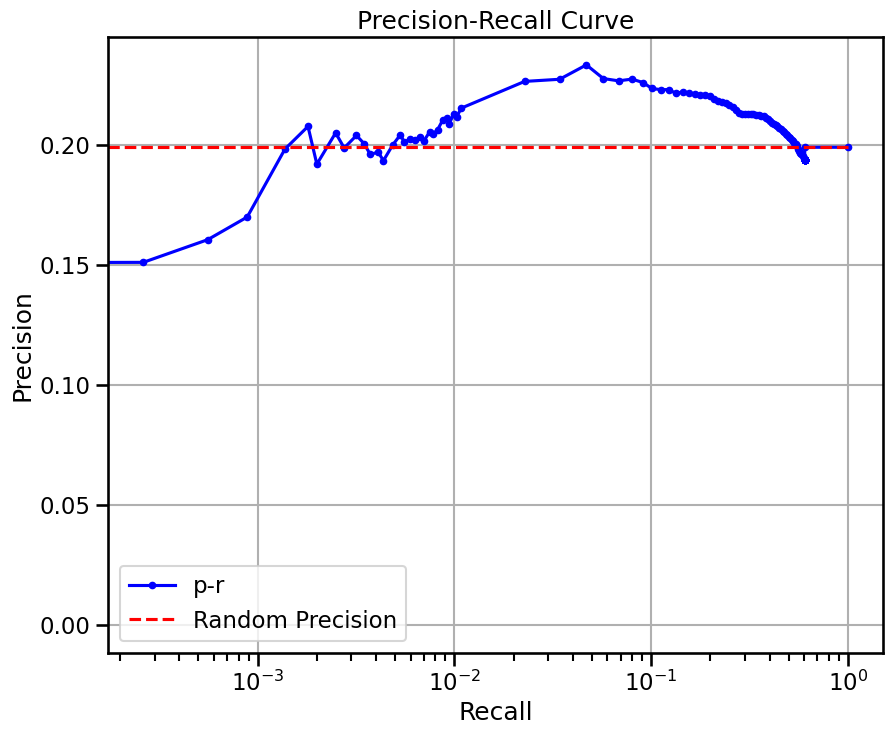

In [25]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['genie3_tran_chip'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.06571045126656601 
recall:  0.5742279124315872 
random precision: 0.07958310647896087


 67%|███████████████████████████████████████████████████████                           | 86/128 [00:00<00:00, 432.84it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 436.23it/s]


Area Under Precision-Recall Curve (AUPRC):  0.06983046795502276
EPR: 0.7490429321747619


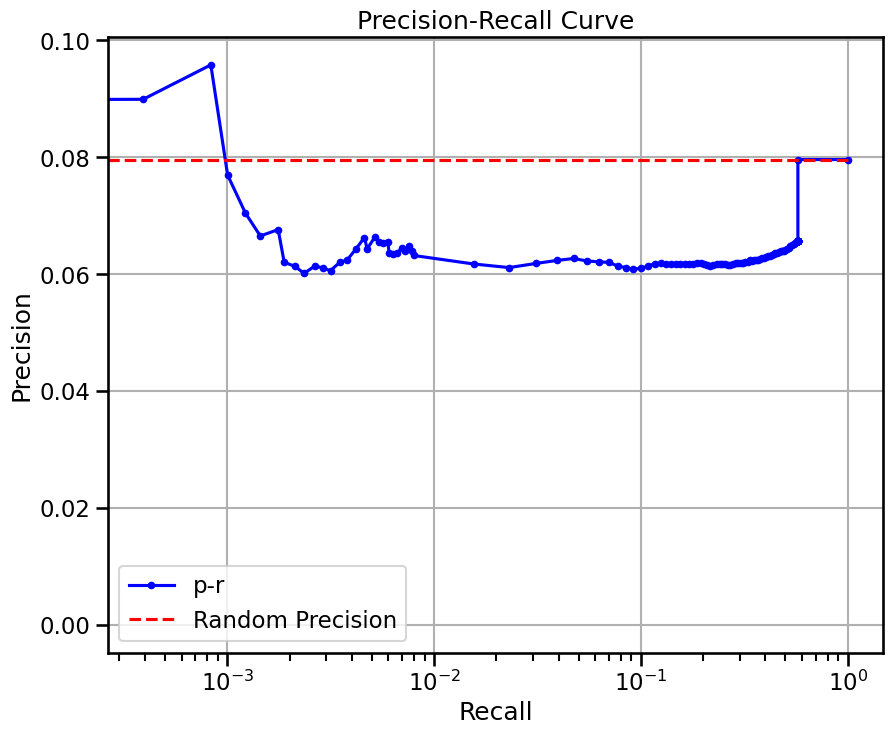

In [26]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['genie3_tran_ko'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

# zhao

In [27]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 36199 renamining
filtered out 0 cells, 36199 renamining
Removed 0 genes.
startin QC
Seeing 828 outliers (2.29% of total dataset):
done


(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 109.24 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.05610397575157155 
recall:  0.866326716445092 
random precision: 0.05307057390833704


 77%|███████████████████████████████████████████████████████████████▍                  | 99/128 [00:00<00:00, 989.84it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1028.46it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05646185725855847
EPR: 1.1420200401634584


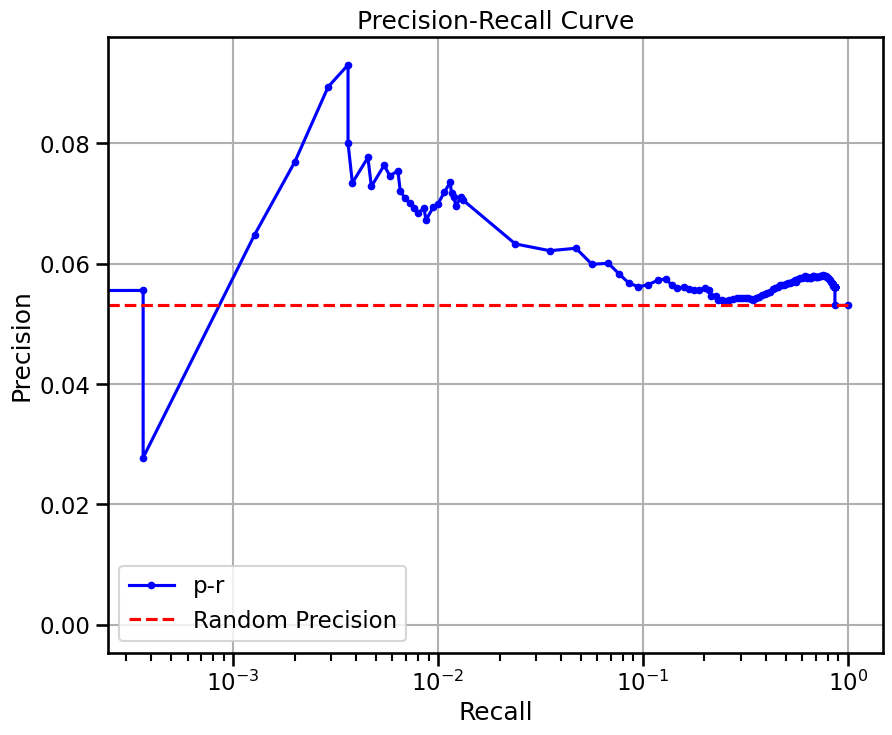

In [28]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20,
                            regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
metrics['genie3_tf_zhao'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 294.02 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.058321325090255505 
recall:  0.6854853396466946 
random precision: 0.05307057390833704


  0%|                                                                                            | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1870.15it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05731930368702575
EPR: 1.281676636605246


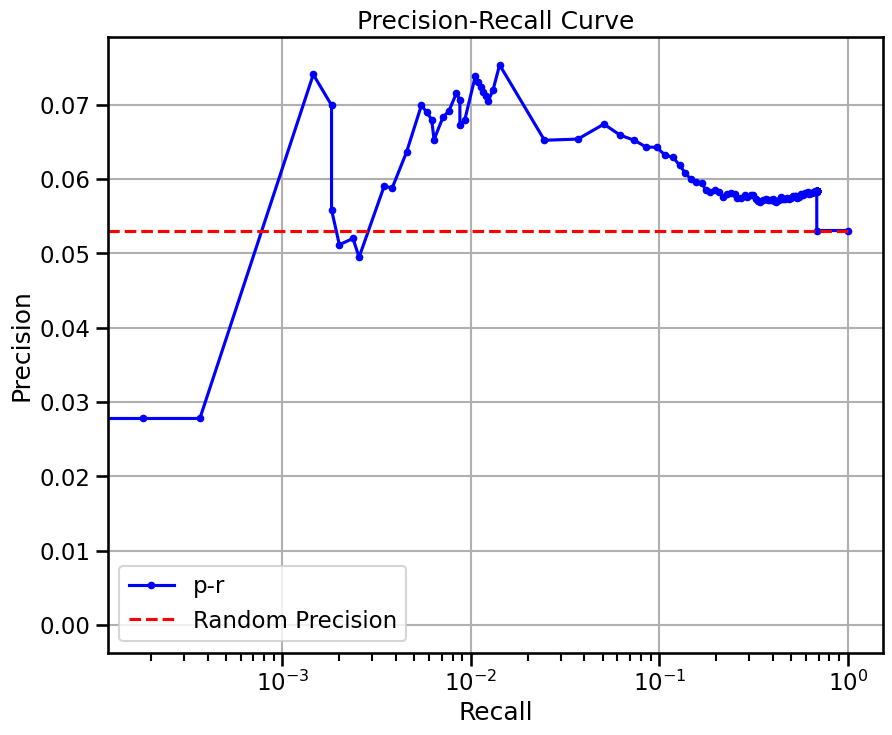

In [30]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:MAXCELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var['symbol'] = make_index_unique(
    genie_grn.var['symbol'].astype(str))
genie_grn.var.index = genie_grn.var['symbol']
metrics['genie3_zhao'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [32]:
metrics

{'genie3_tf_han': {'precision': 0.02843960638719677,
  'recall': 0.7882117882117882,
  'rand_precision': 0.027387640449438203,
  'auprc': 0.028807301001836202,
  'epr': 1.139258511354377},
 'genie3_tf_han_base': {'enriched_terms_Targets': ['celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Retinal pigment epithelial cells',
   'celltype.gmt__Merkel cells',
   'celltype.gmt__Myofibroblasts',
   'celltype.gmt__Radial glial cells',
   'celltype.gmt__Naive B cells',
   'celltype.gmt__Memory B cells',
   'celltype.gmt__Plasma B cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__HSC/MPP cells',
   'celltype.gmt__Non-classical monocytes',
   'celltype.gmt__Pro-B cells',
   'celltype.gmt__Neuroepithelial cells',
   'celltype.gmt__Pericytes',
   'celltype.gmt__Retinal ganglion cells'],
  'significant_enriched_TFtargets': 5.660377358490566,
  'precision': 0.0015509777705755702,
  'recall': 0.7478670334281319,
  'rand_precision': 0.0015216081

In [10]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    elif k.split('_')[-1] == "ko":
        res.append([k.split('_')[-2]+"_ko", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    elif k.split('_')[-1] == "chip":
        res.append([k.split('_')[-2]+"_chip", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,han,1.139259,0.028807,0.027388,True
1,han_chip,1.342218,0.284262,0.253665,True
2,han_ko,0.913178,0.069567,0.076627,True
3,han,1.473490,0.095461,0.076627,False
4,han_chip,0.963944,0.242918,0.253665,False
5,han_ko,1.473490,0.095461,0.076627,False
6,mine,1.364282,0.037422,0.031787,True
7,mine,1.350774,0.036631,0.031787,False
8,tran,0.428686,0.030589,0.040477,True
9,tran_chip,1.490134,0.229847,0.198858,True


In [14]:
df2[:4]

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,han,1.781345,0.001695,0.001522,5.660377,False,True
1,han,9.071017,0.004797,0.001522,7.547170,True,False
2,mine,9.414169,0.006973,0.001508,2.500000,True,True
3,mine,0.824358,0.001692,0.001508,5.000000,False,False
